In [1]:
# goals for this notebook: develop code for one TC that can be iterated over all cases!

# first, chop flight level data down to just the portion found in the tc eye (this has been done before).
# then, without coarsening the resolution, make pdfs of vertical velocity (centered on 0 m/s) for that eye pass... any outliers?

# second, calculate and plot covariances between vertical velocity and cloud heights. This might be a bit trickier;
# maybe define an inversion layer and normalize to that height? So any clouds above the inversion would be positive and clouds
# under the inversion are negative. This would allow for ++ and -- covariances according to what i'm looking for!


In [ ]:
# create the w distribution and covariance plots shown below automatically!
import os
os.chdir("/Users/etmu9498/research/code/scripts/statistics/")
import wh_covariances

wh_covariances.plot( tc='all')

In [31]:
# import...
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import warnings

os.chdir("/Users/etmu9498/research/code/scripts")
import make_plots_new_heights
import tc_metadata
import helper_fns
import cloud_height

os.chdir("/Users/etmu9498/research/code/scripts/plotting/")
import simple_flight_level_plot


In [49]:
# metadata for this case
tcname = 'sam'
dataset = 3
metadata = tc_metadata.all_data(tc=tcname)

crl_path = metadata['um_crl_path']
fl_path = metadata['new_flight_data_path']

tdr_name, crl_name = tc_metadata.choose_new_data( tcname, dataset)
fl_name = tc_metadata.choose_new_in_situ_name( tcname, dataset)

print( crl_name)
print( fl_name)

crl-sam-09-27-eye-2.nc
in-situ-sam-09-27-eye-2.nc


In [50]:
# load crl and flight level data

# crl
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)
# fl
os.chdir( fl_path)
fl_data = xr.open_dataset( fl_name)

fl_data

<xarray.Dataset>
Dimensions:            (index: 32852, time: 32852)
Coordinates:
  * index              (index) int64 0 1 2 3 4 ... 32847 32848 32849 32850 32851
  * time               (time) float64 18.17 18.17 18.17 ... 27.53 27.53 27.53
Data variables: (12/137)
    IWG1_NAMES         (index) object ...
    TIME               (index) object ...
    LATref             (index) object ...
    LONref             (index) object ...
    ALTref             (index) object ...
    GPS_GeoidHt.3      (index) float64 ...
    ...                 ...
    dt                 (index) datetime64[ns] ...
    float_time         (index) float64 ...
    str_time           (index) object ...
    rollval            (index) float64 ...
    pitchval           (index) float64 ...
    distance           (time) float64 ...

In [51]:
########################################
# task 1: spatially exploring data and creating initial probability distribution plots!!
########################################

In [52]:
# helper function used to turn string w values into floats
def in_situ_to_float( return_var):
    return_var_temp = np.zeros( len( return_var))
    for line_ind in range( len( return_var)):
        if return_var[ line_ind] == '':
            return_var_temp[line_ind] = np.nan
        else:
            return_var_temp[ line_ind] = float( return_var[ line_ind])
    return return_var_temp

In [53]:
# clip crl and fl data to fit eyewall lims

# find eyewall lims
distlims = metadata['eyewall_dists_no_eyewalls'][dataset]

print( distlims)

# crl indices
crl_lim0 = (np.abs(crl_data.in_situ_distance - distlims[0] )).argmin().values
crl_lim1 = (np.abs(crl_data.in_situ_distance - distlims[1] )).argmin().values

# fl indices
# find the closest fl time to crl time at eye limits
fl_lim0 = (np.abs( fl_data.time - crl_data.time[crl_lim0] )).argmin().values
fl_lim1 = (np.abs( fl_data.time - crl_data.time[crl_lim1] )).argmin().values

# clip down important fields from datasets!
w = in_situ_to_float( fl_data['UWZ.d'][ fl_lim0 : fl_lim1] )
fl_dist = fl_data.distance[ fl_lim0 : fl_lim1]

expand_ind = 500
w_expand = in_situ_to_float( fl_data['UWZ.d'][ fl_lim0 - expand_ind : fl_lim1 + expand_ind] )
dist_expand = fl_data.distance[ fl_lim0 - expand_ind : fl_lim1 + expand_ind]

# print( crl_data.time[ crl_lim0])
# print( fl_data.time[ fl_lim0])

print( crl_data.in_situ_distance[ crl_lim1].values)
print( fl_data.distance[ fl_lim1].values)


(0, 31)


C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\xarray\core\dataarray.py:4860: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\xarray\core\dataarray.py:4860: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\xarray\core\dataarray.py:4860: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis 

30.882750000000442
30.882750000000442


In [54]:
# find eye cloud heights
cloud_heights, xaxis = cloud_height.find_cloud_heights( crl_name, -30, crl_lim0, crl_lim1, xaxis='in-situ-dist', crl_path=crl_path, new_heights=True)


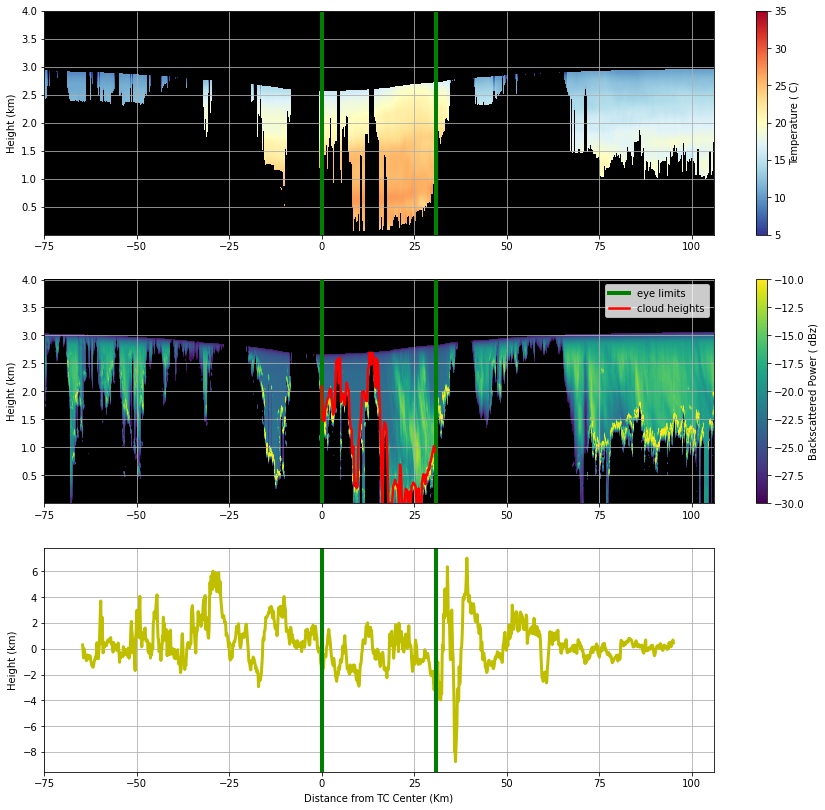

In [55]:
# make simple comparison plots
plt.figure( figsize=(15, 14))

pad = 75

plt.subplot(311)
make_plots_new_heights.plot_T( crl_path, crl_name, xaxis = 'in-situ-dist')

plt.xlim( [distlims[0] - pad, distlims[1] + pad])
plt.axvline( x= distlims[0], c='g', linewidth=4)
plt.axvline( x= distlims[1], c='g', linewidth=4)

plt.subplot(312)
make_plots_new_heights.plot_power_ch1( crl_path, crl_name, xaxis = 'in-situ-dist')

plt.xlim( [distlims[0] - pad, distlims[1] + pad])
plt.axvline( x= distlims[0], c='g', linewidth=4)
plt.axvline( x= distlims[1], c='g', linewidth=4, label='eye limits')

# also add cloud heights for testing!
plt.plot( xaxis, cloud_heights, c='r', linewidth = 2.5, label = 'cloud heights')
plt.legend(loc='upper right')

plt.subplot(313)
# plt.plot( fl_data.distance, in_situ_to_float( fl_data['UWZ.d']), c='y', linewidth=3)
# plt.plot( fl_dist, w, c='y', linewidth=3)
plt.plot( dist_expand, w_expand, c='y', linewidth=3)

plt.grid('on')
plt.xlabel("Distance from TC Center (Km)")
plt.ylabel("Height (km)")
helper_fns.add_blank_colorbar()

plt.xlim( [distlims[0] - pad, distlims[1] + pad])
plt.axvline( x= distlims[0], c='g', linewidth=4)
plt.axvline( x= distlims[1], c='g', linewidth=4)


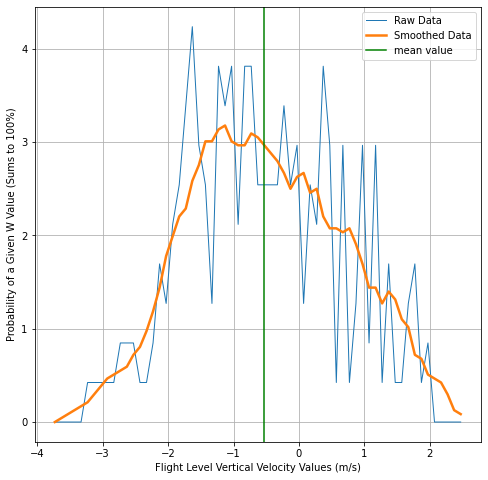

In [56]:
# make a simple pdf of w variations! With manual binning (ex code taken from cloud_height_pdfs_all_one_figure.py)

wmin = np.nanmin( w)
wmax = np.nanmax( w)
wmean = np.nanmean( w)

# initial variables
width = .1
smoothwidth = 10
w_bin=np.arange( wmin - .5, wmax+.5, width)
meanw_count = []

# do this for every w bin
for newi in w_bin:

    # find the points that fall within this height bin for this step
    res=np.where(np.logical_and( w >= newi - width / 2., w <= newi + width / 2. ))

    # append the count to the list!
    meanw_count.append( len( res[0]) / len( w))





# smooth data before plotting to eliminate noise
box_pts = smoothwidth
box = np.ones(box_pts)/box_pts
prob_smooth = np.convolve( meanw_count, box, mode='same')

# make the plots!
plt.figure( figsize=(8, 8))
plt.ylabel("Probability of a Given W Value (Sums to 100%)")
plt.xlabel("Flight Level Vertical Velocity Values (m/s)")
plt.grid('on')

# plot the raw and smoothed data
plt.plot(w_bin, np.array( meanw_count) * 100, linewidth=1, label="Raw Data")
plt.plot(w_bin, prob_smooth * 100, linewidth=2.5, label="Smoothed Data")

plt.axvline(x=wmean, c='g', label='mean value')
plt.legend()

In [57]:
########################################
# task 2: trying to calculate covariances using vertical velocities and cloud top heights!
########################################

In [58]:
# this function will hopefully find covariances easily! Taken from Stull 2.4.5a
# var1 and var2 should be lists or numpy arrays, and they must be the same lengths
def covar( var1, var2):
    
    # make sure variables are numpy arrays
    var1, var2 = np.array( var1), np.array( var2)

    # find the lengths of the variables (N) and mean values
    if len( var1) == len( var2):
        N = len( var1)
    else:
        print( "Covariance error. Please input arrays of equal lengths!")    
    mean1, mean2 = np.nanmean( var1), np.nanmean( var2)
    
    # save 
    sum = 0
    for i in range( N - 1):
        sum += ( var1[i] - mean1) * ( var2[i] - mean2)
        
    return sum / N



# this function is similar to the one above, but it returns an array of perturbations, not a covariance!
def simple_perturb( var):
    # make sure variables are numpy arrays
    var = np.array( var)
    mean = np.mean( var)
  
    return var - mean

In [59]:
# scale w to match coarser crl cloud top heights for covariance analysis!

# another possibility: scale cloud heights UP to match the size of the flight level data! This honestly might be a 
# better approach, as filling in data points might be easier than scaling down a noisy, high resolution dataset.

# also, definitely consider smoothing flight level data for better accuracy; it seems like we did this with tower data
# in BL class! 
# any precedent for this in the literature?

236
118
118


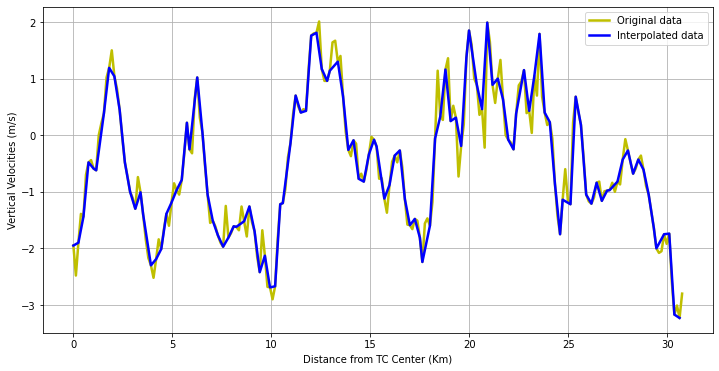

In [60]:
# test 1: using the interp function like what was done for P-3 dips (see get_p3_heights.interp_data2() )
crl_dist = crl_data.in_situ_distance[ crl_lim0:crl_lim1]

wnew = np.interp( crl_dist, fl_dist, w)

print( len( w))
print( len( wnew))
print( len( crl_dist))

# plot the two to compare how well the interpolation worked!
plt.figure( figsize=(12, 6))
plt.grid('on')
plt.xlabel( "Distance from TC Center (Km)")
plt.ylabel( "Vertical Velocities (m/s)")

lw=2.5
plt.plot( fl_dist, w, c='y', linewidth=lw, label='Original data')
plt.plot( crl_dist, wnew, c='b', linewidth=lw, label='Interpolated data')

plt.legend()

118
118
-0.06470859097911409


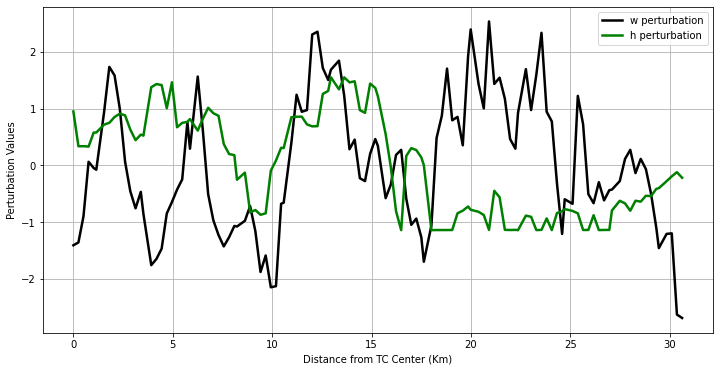

In [61]:
# find and print covariance value for this eye! Also plot height and w perturbs together
heights = cloud_heights

print( len( wnew))
print( len( heights))

w_height_covar = covar( wnew, heights)
wprime = simple_perturb( wnew)
hprime = simple_perturb( heights)

print( w_height_covar)

plt.figure( figsize=(12, 6))
plt.xlabel( "Distance from TC Center (Km)")
plt.ylabel( "Perturbation Values")
plt.grid('on')

lw=2.5
plt.plot( crl_dist, wprime, c='k', linewidth=lw, label='w perturbation')
plt.plot( crl_dist, hprime, c='g', linewidth=lw, label='h perturbation')

plt.legend()